# FXa protein: 30x4 Cross Validation
## Data load and preprocessing

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%run ../modules/run_or_load_decorator.py
%run ../modules/plotting_metrics.py

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
%run ./1_Helper_functions.ipynb

In [6]:
protein_name='fxa'
file_name = '../../../FXa/ANALISIS/6_Machine_Learning_Models/' + \
'df_DkSc_results_COCRYS_DEKOIS_DUD.pkl'
X_merged_dksc = pd.read_pickle(file_name)
y_true_merged = X_merged_dksc['activity']
X_merged_dksc = X_merged_dksc.drop('activity', axis=1)
X_merged_dksc.shape

# Simplify the names
X = X_merged_dksc.values
y = y_true_merged.values


R_a = round(y.sum() / len(y), 3)
print(X.shape)
print(y.sum())
print('Ra =', R_a)

(6233, 136)
300
Ra = 0.048


## Estimators
### ML Classifiers

In [7]:
from sklearn.dummy import DummyClassifier

hyparams = {'strategy': "stratified"}
dclf = DummyClassifier(**hyparams)

In [8]:
from sklearn.linear_model import LogisticRegression 

hyparams = {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear', 'max_iter':400}
lr = LogisticRegression(**hyparams)

In [9]:
from xgboost import XGBClassifier

hyparams ={'subsample': 0.5, 'n_estimators': 200, 
           'max_depth': 10, 'learning_rate': 0.1, 
           'gamma': 1, 'colsample_bytree': 0.5, 'alpha': 0.5}
xgb = XGBClassifier(**hyparams)

In [10]:
# ML Classifier
ml_classifiers = {
    'lr': lr,
    'xgb': xgb,
    'dclf': dclf
}

# update names
ml_classifiers = {f'ml_{name}': clf 
                for name, clf in ml_classifiers.items()}

### Consensus Scorings

In [11]:
%run ../6_Machine_Learning_Models/5_Helper_Consensus_Scoring.ipynb

cs_functions = {
    'MEAN': get_mean_score,
    'MAX': get_max_score,
    'MIN': get_min_score,
}

# update names
cs_functions = {f'cs_{name}': func 
                for name, func in cs_functions.items()}

### Estimators dictionary 

In [12]:
estimators = {**ml_classifiers, **cs_functions}

### Evaluation metrics 

In [13]:
metrics=dict(roc_auc = {'metric_name': 'roc_auc'},
             nef_05_Ra = {'metric_name': 'ef', 
                    'fraction': R_a, 'method':'normalized'},
             pROC = {'metric_name': 'p_roc'},
             pr_auc = {'metric_name': 'pr_auc'}
            )

# 30x4 CV evaluation

In [14]:
# Save the results to a file to ommit repeate the analysis
@run_or_load_joblib
def nk_rep_cross_validation_SAVE(filename, **kwargs):
    return nk_rep_cross_validation(**kwargs)

In [15]:
%run ./1_Helper_functions.ipynb


The following procedure performs a P number of assays of K-fold CV.
To track which instances where used for training and testing the `nk_rep_cross_validation()` function also returns the predictions of each model and the split sets, in order to identify which observations were correctly predicted.

- y_preds:
    - Contains the PxK predictions of each method
- splits
    - List that contains PxK tuples with two elements: The train and test indexes.

In [16]:
%%time

n_repeats = 30
n_splits = 4

# **********************
# Perform the evaluation
# **********************
evaluation_name=f'{n_repeats}x{n_splits}cv'
cv30x4, y_preds, splits = nk_rep_cross_validation_SAVE(
    filename=f'./cachedir/{evaluation_name}_{protein_name}',
    estimators=estimators, X=X, y=y, metrics=metrics, 
                      n_repeats=n_repeats, n_splits=n_splits,
    y_preds_return=True,
    random_state=42)

# Rename columns 
full_names = ['Log. Reg.', 'XGB', 'DummyClf', 'csMEAN', 'csMAX', 'csMIN']
# full_names = ['1-NN', 'Log. Reg.', 'XGB', 'DummyClf', 'csMEAN', 'csMAX', 'csMIN', 'csVOTE']
new_names = dict(zip(
    [*cv30x4.columns],
    full_names))
cv30x4 = cv30x4.rename(columns=new_names)

# ***************************
# Drop 1NN and csVOTE methods
# ***************************
# cv30x4 = cv30x4.drop(['1-NN', 'csVOTE'], axis=1)
# Update Full names list
full_names = ['Log. Reg.', 'XGB', 'DummyClf', 'csMEAN', 'csMAX', 'csMIN']

# **********************************
# Extract the individual predictions
# **********************************
# y_preds: Model predictions
# get the test indices
test_sets_idxs = [i[1] for i in splits]

File loaded: ./cachedir/30x4cv_fxa
CPU times: user 86.2 ms, sys: 21.8 ms, total: 108 ms
Wall time: 139 ms


In [30]:
final_ranks

,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,18.0,18.0,16.0,9.0,12.0,9.0,21.0,21.0,17.0,21.0,...,4.0,18.0,18.0,14.0,5.0,19.0,9.0,15.0,9.0,12.0
1,279.0,97.0,267.0,191.0,176.0,234.0,376.0,62.0,107.0,175.0,...,108.0,194.0,256.0,104.0,285.0,696.0,74.0,476.0,125.0,196.0
2,83.0,120.0,123.0,91.0,54.0,138.0,45.0,152.0,66.0,53.0,...,286.0,345.0,53.0,152.0,54.0,75.0,120.0,69.0,429.0,133.0
3,42.0,167.0,171.0,150.0,66.0,123.0,41.0,63.0,86.0,66.0,...,80.0,29.0,88.0,105.0,84.0,118.0,43.0,116.0,48.0,28.0
4,404.0,421.0,207.0,282.0,535.0,455.0,405.0,358.0,106.0,390.0,...,473.0,152.0,246.0,702.0,447.0,485.0,432.0,597.0,689.0,275.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6228,533.0,443.0,932.0,805.0,523.0,408.0,396.0,638.0,638.0,301.0,...,142.0,902.0,615.0,318.0,412.0,680.0,1068.0,291.0,690.0,201.0
6229,1434.0,1035.0,1362.0,1153.0,916.0,1290.0,806.0,327.0,909.0,1280.0,...,1243.0,892.0,925.0,763.0,1283.0,441.0,642.0,919.0,1033.0,1120.0
6230,1436.0,1399.0,1202.0,647.0,1206.0,1165.0,911.0,991.0,1415.0,1235.0,...,1106.0,1483.0,804.0,1123.0,1034.0,934.0,1157.0,1178.0,579.0,1409.0
6231,659.0,970.0,534.0,380.0,832.0,719.0,1290.0,526.0,343.0,1000.0,...,969.0,628.0,775.0,600.0,1000.0,838.0,607.0,653.0,726.0,686.0


In [34]:
# aun se necesita quedarse solo con los del test set
k=4
test_sets_idxs = [i[1] for i in splits]

# unir las predicciones con los indices
m_name = 'ml_xgb'
P=120
# Iterar entre el numero de sets = PxK
# Como resultado se obtiene una lista con PxK elementos, cada uno es un Dataframe con una unica columna
# As a result we get a list of PxK elements, each one is a Dataframe with just one column
sets_preds = [pd.DataFrame(y_preds[m_name][i], index=test_set).rank(ascending=False)
     for i, test_set in enumerate(test_sets_idxs)]
# Concatenar por pares la lista de dataframes
# Now we need to concat each K consecutive elements to get the full column with all observations
# Concat rows

def every_k_elements(array, k):
    assert len(array) % k == 0
    chunks = []
    for i in range(0, len(array), k):
        chunks.append( array[i: i+k])
    return chunks

chunks = every_k_elements(sets_preds, k=k)

final_ranks = pd.concat([pd.concat(chunk, axis=0) for chunk in chunks], axis=1)

# .mean(axis=1).rank()

# # Identify the molecules
# # final_ranks.index = y_true_merged.index
# final_df = pd.DataFrame({'y': y_true_merged.values, 'rank': final_ranks.values}, index= y_true_merged.index)
# final_df

# final_df.query('y == 1').median(axis=0)
# final_df.query('y == 0').median(axis=0)
n_a = y_true_merged.sum()
thr = n_a / k
print(thr)
df_fin = final_ranks.applymap(lambda x: x < thr).sum(axis=1)
df_fin = pd.DataFrame({'y': y_true_merged.values, 'rank': df_fin.values}, index= y_true_merged.index)
df_fin.sort_values('rank', ascending=False).query('y == 1')




75.0


y  rank
library name              
COCRYS  RPR        1    30
DUD     ligand_76  1    30
COCRYS  M37        1    30
        LGM        1    30
        LGL        1    30
...               ..   ...
        4O4        1     0
        4O1        1     0
        48U        1     0
        6XS        1     0
        VYR        1     0

[300 rows x 2 columns]

In [126]:
%run Friedman_and_Nemenyi_test.ipynb
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


## AUC-ROC

In [200]:
# ROC-AUC
metric_name='roc_auc'

# Normality
display(multi_norm_test(cv30x4, metric=metric_name))
# Homocedasticity
display(multi_homovar_test(cv30x4, metric=metric_name))

display(friedmanTest(cv30x4.loc[metric_name]))

df_R = order_df(cv30x4, metric_name).loc[metric_name]
df_Rmelted = pd.melt(df_R, var_name='method', value_name='score')

# Single conformation reference values
single_mean, single_max = n_hold_out_single_performance(X, y, 
                            metrics[metric_name], n_reps=30, test_size=0.5, random_state=42)

,Log. Reg.,XGB,DummyClf,csMEAN,csMAX,csMIN
Normality,1,1,1,1,1,1


,statistic,p
Bartlett,176.855402,2.511479e-36


,chi^2,dof,p_value
Friedman Test,593.861905,5,4.286126e-126


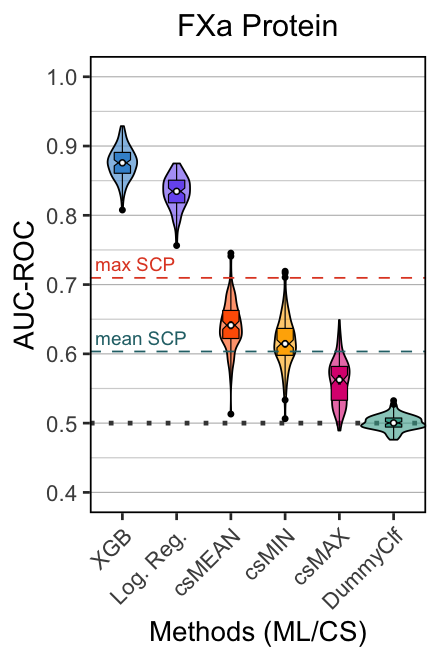

In [170]:
%%R -i full_names -i df_R -i single_mean -i single_max  -w 2.2 -h 3.3 --units in -r 200

source('./plotSwarmBox.R')

cbbPalette <- c( '#785EF0', '#3F93D2', '#44AA99', '#FE6100', '#DC267F', '#FFB000')
names(cbbPalette) <- full_names

p = plot_violin(df_R, cbbPalette, decreasing_order = TRUE, y_min=0.4, y_max=1,
              dot_size=4, scale='area', violin_width=1.2) +
add_ref_values('mean SCP', single_mean, color='#297177', size=2.4, y_add=0.02) + 
add_ref_values('max SCP', single_max, color='#E1492B', size=2.4, y_add=0.02) +
ggtitle('FXa Protein')

# Save the picture
protein_name <- 'fxa'
methodology <- '30x4CV'
metric <- 'ROC-AUC'
filename <- paste0('images/fxa/', paste(protein_name, methodology, metric, 'violin.pdf', sep='_'))
ggsave(filename, plot=p, width=2.2, height= 3.3) 
p

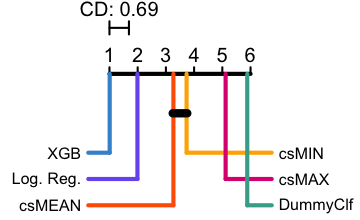

In [178]:
%%R -i df_R -i full_names -w 1.8 -h 1.1 --units in -r 200
library(scmamp)

source('./plotCD.R')

cbbPalette <- hue_pal()(ncol(df_R))
cbbPalette <- c( '#785EF0', '#3F93D2', '#44AA99', '#FE6100', '#DC267F', '#FFB000')
names(cbbPalette) <- full_names

# Save the figure
protein_name <- 'fxa'
methodology <- '30x4CV'
metric <- 'ROC-AUC'
filename <- paste0('images/fxa/', paste(protein_name, methodology, metric, 'nemenyiCD.pdf', sep='_'))

# pdf(filename, 1.8, 1.1)
# plotCD_color(df_R, alpha=0.05, cex=.6, labels.cex=0.48, colPalette=cbbPalette, side_marging=12)
# dev.off()

plotCD_color(df_R, alpha=0.05, cex=.6, labels.cex=0.48, colPalette=cbbPalette, side_marging=12)

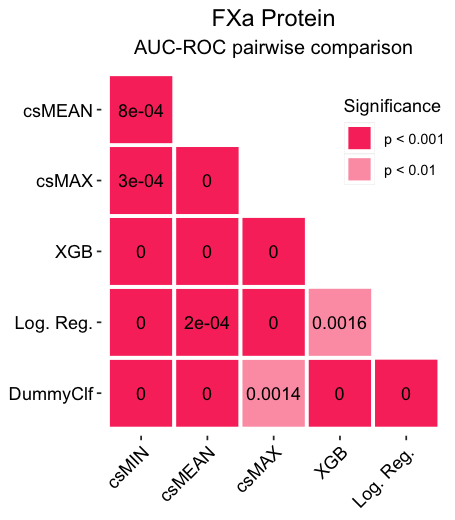

In [201]:
%%R -i df_R -w 3.5 -h 4 --units in -r 130

source('./plot_p_vals_heatmap.R')

p = plot_p_vals_heatmap(df_R) +
labs(title='FXa Protein', subtitle="AUC-ROC pairwise comparison")

# Save the picture
protein_name <- 'FXa'
methodology <- '30x4CV'
metric <- 'ROC-AUC'
filename <- paste0('images/fxa/', paste(protein_name, methodology, metric, 'significance.pdf', sep='_'))
ggsave(filename, plot=p, width=3.5, height= 4)
p

## pAUC-ROC Normalized

In [131]:
# Random value given n_a and N
test_size=0.25
N = y.size*test_size
n_a = y.sum()*test_size
print(N, n_a)
pROC_base_random = pROC_auc_rand(N, n_a, normalized=True)
print('Max pACU-ROC (non-normalized):', 1/N)
pROC_base_random

1558.25 75.0
Max pACU-ROC (non-normalized): 0.0006417455478902615


0.13594271974047575

In [132]:
# ROC-AUC
metric_name='pROC'

# Normality
display(multi_norm_test(cv30x4, metric=metric_name))
# Homocedasticity
display(multi_homovar_test(cv30x4, metric=metric_name))
# Friedman test
display(friedmanTest(cv30x4.loc[metric_name]))

df_R = order_df(cv30x4, metric_name).loc[metric_name]
df_Rmelted = pd.melt(df_R, var_name='method', value_name='score')

# Single conformation reference values
single_mean, single_max = n_hold_out_single_performance(X, y, 
                            metrics[metric_name], n_reps=30, test_size=0.5, random_state=42)

,Log. Reg.,XGB,DummyClf,csMEAN,csMAX,csMIN
Normality,1,1,1,1,1,1


,statistic,p
Bartlett,133.170941,5.052159e-27


,chi^2,dof,p_value
Friedman Test,582.595238,5,1.164542e-123


In [133]:
%%R -i full_names -i df_R -i single_mean -i single_max -ipROC_base_random -w 6 -h 4 --units in -r 300
source('./plotSwarmBox.R')

cbbPalette <- hue_pal()(ncol(df_R))
names(cbbPalette) <- full_names

# plot_swarm_box(df_R, cbbPalette, decreasing_order = FALSE, y_min=0.0, y_max=1., 
#                dot_size=4, bin_width=0.002,
#                y_label='AUC-pROC', base_h_line=pROC_base_random) +
# add_ref_values('min SCP', single_mean, color='cadetblue4') + 
# add_ref_values('max SCP', single_max, color='coral1')

In [134]:
%%R -i df_R -i full_names -w 5 -h 2 --units in -r 150
library(scmamp)

source('./plotCD.R')

cbbPalette <- hue_pal()(ncol(df_R))
names(cbbPalette) <- full_names

par(family = "Trebuchet MS")
# plotCD_color(df_R, alpha=0.05, cex=.9, colPalette=cbbPalette)

In [135]:
%%R -i df_R -w 4 -h 4 --units in -r 130

source('./plot_p_vals_heatmap.R')

# plot_p_vals_heatmap(df_R)

## EF 5% = Ra

In [202]:
# ROC-AUC
metric_name='nef_05_Ra'

# Normality
display(multi_norm_test(cv30x4, metric=metric_name))
# Homocedasticity
display(multi_homovar_test(cv30x4, metric=metric_name))
# Friedman test
display(friedmanTest(cv30x4.loc[metric_name]))

df_R = order_df(cv30x4, metric_name).loc[metric_name]
df_Rmelted = pd.melt(df_R, var_name='method', value_name='score')

# Single conformation reference values
single_mean, single_max = n_hold_out_single_performance(X, y, 
                            metrics['nef_05_Ra'], n_reps=30, test_size=0.5, random_state=42)

,Log. Reg.,XGB,DummyClf,csMEAN,csMAX,csMIN
Normality,1,1,1,1,1,1


,statistic,p
Bartlett,57.608156,3.788842e-11


,chi^2,dof,p_value
Friedman Test,578.957143,5,7.113620e-123


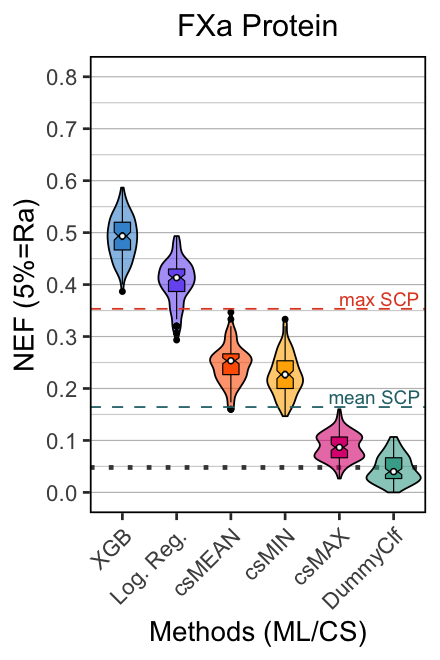

In [164]:
%%R -i full_names -i df_R -i R_a -i single_mean -i single_max  -w 2.2 -h 3.3 --units in -r 200

source('./plotSwarmBox.R')

cbbPalette <- c( '#785EF0', '#3F93D2', '#44AA99', '#FE6100', '#DC267F', '#FFB000')
names(cbbPalette) <- full_names

p = plot_violin(df_R, cbbPalette, decreasing_order = TRUE, y_min=0.0, y_max=0.8,
              dot_size=4, scale='area', violin_width=1., base_h_line=R_a,
               y_label='NEF (5%=Ra)') +
add_ref_values('mean SCP', x=4.8, single_mean, color='#297177', size=2.4, y_add=0.02) + 
add_ref_values('max SCP', x=5, single_max, color='#E1492B', size=2.4, y_add=0.02) +
ggtitle('FXa Protein')

# Save the picture
protein_name <- 'fxa'
methodology <- '30x4CV'
metric <- 'NEF'
filename <- paste0('images/fxa/', paste(protein_name, methodology, metric, 'violin.pdf', sep='_'))
ggsave(filename, plot=p, width=2.2, height= 3.3) 
p

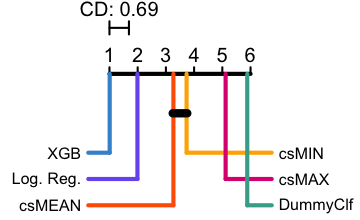

In [175]:
%%R -i df_R -i full_names -w 1.8 -h 1.1 --units in -r 200
library(scmamp)

source('./plotCD.R')

cbbPalette <- hue_pal()(ncol(df_R))
cbbPalette <- c( '#785EF0', '#3F93D2', '#44AA99', '#FE6100', '#DC267F', '#FFB000')
names(cbbPalette) <- full_names

# Save the figure
protein_name <- 'fxa'
methodology <- '30x4CV'
metric <- 'NEF'
filename <- paste0('images/fxa/', paste(protein_name, methodology, metric, 'nemenyiCD.pdf', sep='_'))

pdf(filename, 1.8, 1.1)
plotCD_color(df_R, alpha=0.05, cex=.6, labels.cex=0.48, colPalette=cbbPalette, side_marging=12)
dev.off()

plotCD_color(df_R, alpha=0.05, cex=.6, labels.cex=0.48, colPalette=cbbPalette, side_marging=12)


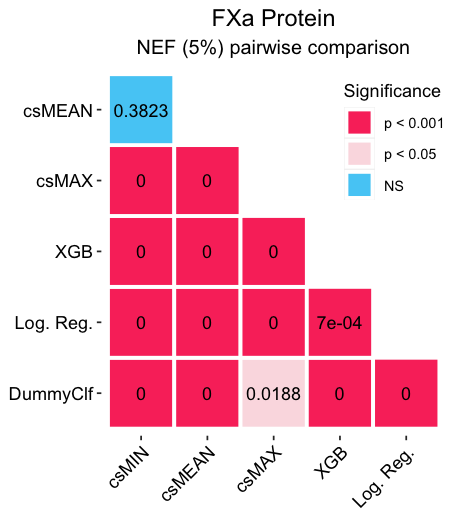

In [203]:
%%R -i df_R -w 3.5 -h 4 --units in -r 130

source('./plot_p_vals_heatmap.R')

p = plot_p_vals_heatmap(df_R) +
labs(title='FXa Protein', subtitle="NEF (5%) pairwise comparison")

# Save the picture
protein_name <- 'fxa'
methodology <- '30x4CV'
metric <- 'NEF'
filename <- paste0('images/fxa/', paste(protein_name, methodology, metric, 'significance.pdf', sep='_'))
ggsave(filename, plot=p, width=3.5, height= 4)
p


# Y-randomization test

In [183]:
%%time 

n_repeats = 10
n_splits = 4

# time 29.5 min
chi_fractions = [1, 0.75, 0.5, 0.25, 0.0]
chi_results = {}
evaluation_name = f'y_scrambling_reps_{n_repeats}x{n_splits}CV'

for chi in chi_fractions:
    filename = f'./cachedir/{evaluation_name}_{protein_name}_chi-{chi}'
    result = nk_rep_cross_validation_scrambling(filename=filename, 
                             random_chi=chi, estimators=estimators, 
                             X=X, y=y, metrics=metrics, 
                             n_repeats=n_repeats, n_splits=n_splits,
                             y_preds_return=True)
    print(f'Fraction chi={chi} finished.')
    chi_results[f'chi_{chi}'] = result

File loaded: ./cachedir/y_scrambling_reps_10x4CV_fxa_chi-1
Fraction chi=1 finished.
File loaded: ./cachedir/y_scrambling_reps_10x4CV_fxa_chi-0.75
Fraction chi=0.75 finished.
File loaded: ./cachedir/y_scrambling_reps_10x4CV_fxa_chi-0.5
Fraction chi=0.5 finished.
File loaded: ./cachedir/y_scrambling_reps_10x4CV_fxa_chi-0.25
Fraction chi=0.25 finished.
File loaded: ./cachedir/y_scrambling_reps_10x4CV_fxa_chi-0.0
Fraction chi=0.0 finished.
CPU times: user 15.2 ms, sys: 5.39 ms, total: 20.6 ms
Wall time: 21.2 ms


## AUC-ROC

In [189]:
df_y_random = get_group_stats(chi_results, metric_name='roc_auc')
df_y_random = df_y_random.replace(new_names)
df_y_random = df_y_random[df_y_random['method'].isin(full_names)]

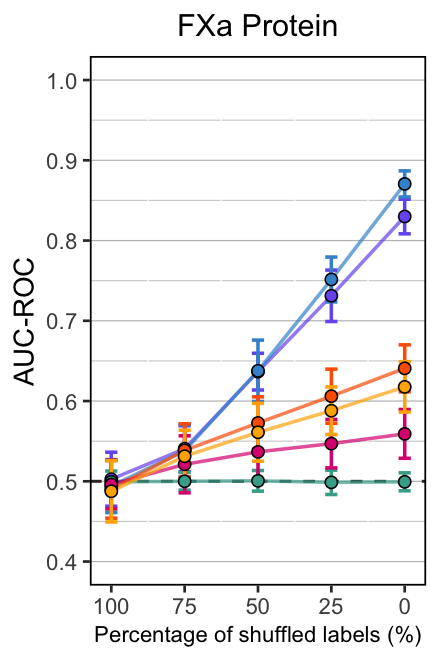

In [196]:
%%R -i df_y_random -i full_names -i df_R -w 2.2 -h 3.3 --units in -r 200

source('./plotSwarmBox.R')

cbbPalette <- c( '#785EF0', '#3F93D2', '#44AA99', '#FE6100', '#DC267F', '#FFB000')
names(cbbPalette) <- full_names

p = plot_lines(df_y_random, cbbPalette, point_size=1.8, line_size=0.6,
           error_size=0.6, error_dodge=0.05, error_width=25) +
ggtitle('FXa Protein')

# Save the picture
protein_name <- 'fxa'
methodology <- 'y-scramb-10x4CV'
metric <- 'AUC-ROC'
filename <- paste0('images/fxa/', paste(protein_name, methodology, metric, '.pdf', sep='_'))
ggsave(filename, plot=p, width=2.2, height= 3.3) 
p

## AUC-pROC Normalized

In [143]:
df_y_random = get_group_stats(chi_results, metric_name='pROC')
df_y_random = df_y_random.replace(new_names)

In [144]:
%%R -i df_y_random -i df_R -i pROC_base_random -w 9 -h 4 --units in -r 130

source('./plotSwarmBox.R')

cbbPalette <- hue_pal()(ncol(df_R))
names(cbbPalette) <- colnames(df_R)

# plot_lines(df_y_random, cbbPalette, y_min=0.0, y_max=1., 
#                y_label='AUC-pROC', base_h_line=pROC_base_random)

## EF 12% 

In [186]:
df_y_random = get_group_stats(chi_results, metric_name='nef_12_Ra')
df_y_random = df_y_random.replace(new_names)
df_y_random = df_y_random[df_y_random['method'].isin(full_names)]

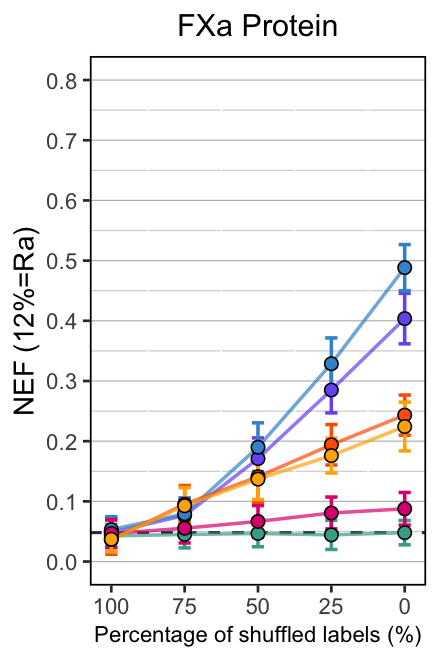

In [188]:
%%R -i df_y_random -i full_names -i R_a -i df_R -w 2.2 -h 3.3 --units in -r 200
 
source('./plotSwarmBox.R')

cbbPalette <- c( '#785EF0', '#3F93D2', '#44AA99', '#FE6100', '#DC267F', '#FFB000')
names(cbbPalette) <- full_names

p = plot_lines(df_y_random, cbbPalette, point_size=2., line_size=0.6,
           error_size=0.6, error_dodge=0.05, error_width=25,
           y_min=0, y_max=0.8, base_h_line=R_a, y_label='NEF (12%=Ra)') +
ggtitle('FXa Protein')

# Save the picture
protein_name <- 'fxa'
methodology <- 'y-scramb-10x4CV'
metric <- 'NEF'
filename <- paste0('images/fxa/', paste(protein_name, methodology, metric, '.pdf', sep='_'))
ggsave(filename, plot=p, width=2.2, height= 3.3) 
p